# Instantaneous analysis of interfaces

---



Copy this script into each of the directories corresponding to the different types of regim we expect to see:
- Gas-liquid
- Border-liquid
- Liquid-liquid


Execute to obtain profiles of the following, relative to an instantaneous interface:
- Density profile for both CO2 and H2O.
- Time averaged cos(theta) for the dipoles of CO2 and H2O.
- Heatmaps giving the frequency of occurence at cos(theta) and distance from WC for CO2. 
- Heatmaps giving the frequency of occurence at cos(theta) and distance from WC for H2O.
- Profile of the degree of hydrogen bonding against distance from interface for both species.  

In [6]:
# will need to initially set path location to whever finalised on_a_WIM module is located. 

import sys
import MDAnalysis as mda
from WillardChandler import WillardChandler
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib as mpl
from matplotlib import cm


# generate output file for storing results. 
if os.path.isdir('./outputs'):
    print('Output directory found.')
else:
    print('Not found. Creating directory.')
    os.mkdir('outputs')

# load trajectories and create the universe. 
pdb = 'ref_coords.pdb'
trj = 'test_2.dcd'
u = mda.Universe(pdb,trj)

Output directory found.


In [7]:
# -----------------------------------------------------
# perform the WC interfacial analysis
# OR load previously generated surface into script. 
# -----------------------------------------------------

WC_inter = WillardChandler(u,lower_z=5,upper_z=95)
result = WC_inter.generate(grid=200,new_inter=True)
WC_inter.save() # NOW DONT SWITCH ON


---------------------
 Loading trajectory  
---------------------

Output directory detected.

Obtaining atom coordinates.
Parsing through frames.
Total: 200.




Number of cores: 24

Generating frames ...


100%|██████████| 200/200 [00:02<00:00, 71.65it/s]


Done



/scratch/sghb2/anaconda3/lib/python3.9/site-packages/MDAnalysis/core/universe.py:449: UserWarning: Residues specified but no atom_resindex given.  All atoms will be placed in first Residue.
  warnings.warn(
/scratch/sghb2/anaconda3/lib/python3.9/site-packages/MDAnalysis/core/universe.py:455: UserWarning: Segments specified but no segment_resindex given.  All residues will be placed in first Segment
  warnings.warn(
/scratch/sghb2/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/scratch/sghb2/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'resnames' Using default value of 'UNK'
  warnings.warn("Found no information for attr: '{}'"
/scratch/sghb2/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for att

---

# Density analysis 

Perform density measurements relative to instantaneous interface.

Water density in red; CO2 density in blue. 





---

In [8]:
# perform density measurements. 
# set the species; binds; lower bound; upper bound. 
data_Oxygen = WC_inter.Density_run('OW',150,-8,2)
data_Carbon = WC_inter.Density_run('C',150,-8,2)

# function for quick plot
#WC_inter.Density_plot(data_Oxygen,data_Carbon)


Obtaining OW density.
Calculating density profile ...


100%|██████████| 200/200 [00:01<00:00, 129.81it/s]


Generating histogram(s)
Done


Obtaining C density.
Calculating density profile ...


100%|██████████| 200/200 [00:00<00:00, 1661.02it/s]


Generating histogram(s)
Done



In [9]:
# create figures directory for generated plots. 
if os.path.isdir('./outputs/figures'):
    print('Figures directory found.')
else:
    print('No figures directory found.')
    print('Create directory ...')
    os.mkdir('outputs/figures')

Figures directory found.


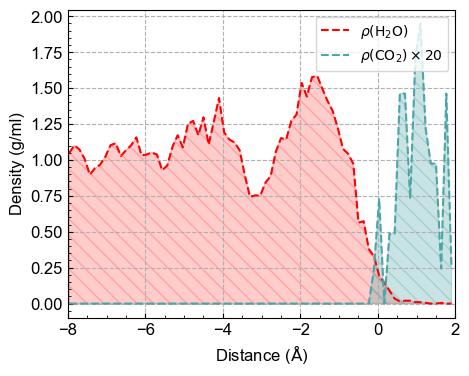

In [10]:
# load data from the generated density data files and plot.
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'


data_Oxygen = np.loadtxt('./outputs/OW_dens.dat')
ox_x = data_Oxygen[:,0]
ox_y = data_Oxygen[:,1]
data_Carbon  = np.loadtxt('./outputs/C_dens.dat')
ca_x = data_Carbon[:,0]
ca_y = data_Carbon[:,1]
ca_y = [i*20 for i in ca_y]

smooth = 2
fig, ax = plt.subplots(figsize=(5,4)) # change the figsize to make appropriate for figure
ax.plot(ox_x[::smooth],ox_y[::smooth],'--',
        color='r',
        label = r'$\rho \mathrm{(H_2O)}$',
        linewidth=1.5)
zeros = [0]*len(ox_x[::smooth])
ax.fill_between(ox_x[::smooth],zeros,ox_y[::smooth],
                color='red',
                alpha=0.2,hatch=r'\\')

if data_Carbon is not None:
    ax.plot(ca_x[::smooth],ca_y[::smooth],'--',
            color='#4ca5a6',
            label = r'$\rho \mathrm{(CO_2)} \times 20$',
            linewidth=1.5)
    zeros = [0]*len(ca_x[::smooth])
    ax.fill_between(ca_x[::smooth],zeros,ca_y[::smooth],
                    color='#4ca5a6',
                    alpha=0.3,hatch=r'\\')
    
ax.set_xlim(-8,2)
#ax.set_ylim(0,1.5)
ax.set_xticks(np.arange(-8,3,2))
ax.set_xlabel('Distance ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Density (g/ml)',size=12)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(ls='--')


ax.legend(loc='upper right')
plt.savefig('./outputs/figures/dens_plot.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

## Orientational analysis

Two sets of plots here. The first giving <cos(theta)>; the second gives heatmap of cos(theta) with distance from the interface.
Bins only counted for <cos(theta)> if hits greater than 0.1*max(hits) for the whole profile, helps to eliminate unecessary noise. 

---

In [3]:
# orientational analysis|
ori_water = WC_inter.Orientation_run('water','time',60,-8,2,vect='WC')



Obtaining orientations.
Calculating orientation profile ...


  6%|▌         | 8/137 [00:00<00:07, 16.40it/s]/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it 

Generating histogram(s)
[-8.357397, -8.39866, -1.4974903, -2.1048915, -9.064363, -0.046331257, -11.889362, -4.2556095, -1.4164553, -3.0931497, -6.1894965, -0.7090385, -11.237937, -4.959675, -9.331514, -5.3000736, -5.195401, 0.42752615, -0.6561426, -4.44267, -1.4278274, 0.016709013, -9.112212, -3.3822863, -10.737496, -5.3934474, -9.473076, -9.425661, -7.657872, -1.125128, -3.5618804, -7.6882687, -6.2826896, -8.737768, -4.475801, -9.180157, -3.8683267, -4.8318105, -3.1250596, -8.911713, -1.0914127, -9.374752, -1.1519815, -10.050454, -1.7354114, -3.9489086, -7.7687006, -2.9561594, -2.8448484, -7.355886, -9.297702, -6.2332606, -11.755079, -0.93000376, -5.441581, -3.4672377, -4.790627, -1.9180039, -6.490311, -8.842132, -1.4022564, -7.2297487, -1.3959305, -2.615738, -3.3337784, -1.6026838, -11.4672165, -7.548924, -5.4842277, -8.989923, -11.7248745, -4.470591, -1.8935213, -3.3543048, -9.872762, -0.99170136, -7.173506, -11.089295, -7.0320444, -6.5591173, -4.5325317, -3.351601, -7.068711, -4.29

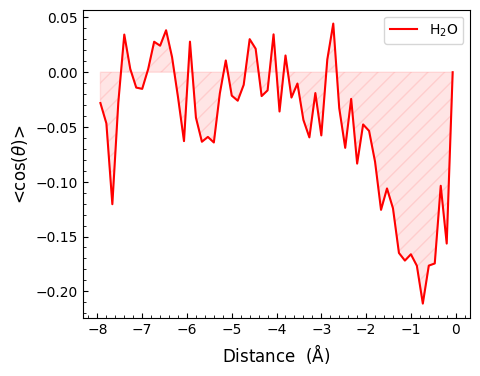

In [4]:
# load the data
h2o_ori = np.loadtxt('./outputs/orientation_water.dat')
h2o_x   = h2o_ori[:,0]
h2o_y   = h2o_ori[:,1]


# plot of the time-averaged profiles
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax=plt.subplots(figsize=(5,4))

# h2o
ax.plot(h2o_x,h2o_y,'-',color='red',label='H$_2$O')
zeros = [0]*len(h2o_x)
ax.fill_between(h2o_x,zeros,h2o_y,color='red',alpha=0.1,hatch=r"//")


ax.set_xlabel('Distance  ($\mathrm{\AA}$)',size=12)
ax.set_ylabel(r'<cos($\theta$)>',size=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both',which='both',direction='in')

ax.legend()
plt.savefig(f'./outputs/figures/ori_profile_gas.png',dpi=800,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

## Hydrogen bonding analysis

Compute the H bonding profile as a function of the distance from the instantaneous interface.

CS suggests implementing change, whereby at each frame I count the number of frames associated with a particular oxygen atom. 
E.g., frame 1: record the number of hits of atom ith ID XXX. Calculate the position of this atom relative to the interface, and place this number of hits there. Possibility that this may be impacted by the wrapping of our coordinates - possible that this may negated by use of the MDAnalysis module, which I believe accounts for wrapping. 

---

In [3]:
result = WC_inter.Hbonds_run(bins=100,lower=-8,upper=2)


Obtaining Hbonds.


  6%|▌         | 8/137 [00:00<00:07, 18.12it/s]/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it 

Don 302
Acc 302
Nul Don 4
Nul Acc 2
Don 310
Acc 310
Nul Don 6
Nul Acc 3
Don 295
Acc 295
Nul Don 6
Nul Acc 6
Don 300
Acc 300
Nul Don 4
Nul Acc 4
Don 313
Acc 313
Nul Don 4
Nul Acc 0
Don 303
Acc 303
Nul Don 1
Nul Acc 5
Don 312
Acc 312
Nul Don 4
Nul Acc 1
Don 314
Acc 314
Nul Don 3
Nul Acc 2
Don 315
Acc 315
Nul Don 3
Nul Acc 2
Don 313
Acc 313
Nul Don 2
Nul Acc 1
Don 301
Acc 301
Nul Don 6
Nul Acc 5
Don 295
Acc 295
Nul Don 5
Nul Acc 6
Don 305
Acc 305
Nul Don 1
Nul Acc 3
Don 303
Acc 303
Nul Don 5
Nul Acc 5
Don 302
Acc 302
Nul Don 6
Nul Acc 9
Don 304
Acc 304
Nul Don 3
Nul Acc 4
Don 311
Acc 311
Nul Don 4
Nul Acc 5
Don 309
Acc 309
Nul Don 5
Nul Acc 3
Don 308
Acc 308
Nul Don 5
Nul Acc 3
Don 297
Acc 297
Nul Don 7
Nul Acc 2
Don 315
Acc 315
Nul Don 0
Nul Acc 3
Don 295
Acc 295
Nul Don 4
Nul Acc 9
Don 298
Acc 298
Nul Don 4
Nul Acc 4
Don 314
Acc 314
Nul Don 5
Nul Acc 5
Don 309
Acc 309
Nul Don 3
Nul Acc 2
Don 305
Acc 305
Nul Don 5
Nul Acc 5
Don 299
Acc 299
Nul Don 5
Nul Acc 10
Don 305
Acc 305
Nul Don 6
N

100%|██████████| 137/137 [00:04<00:00, 29.14it/s]


Nul Don 3
Nul Acc 4
Don 306
Acc 306
Nul Don 2
Nul Acc 6
Don 301
Acc 301
Nul Don 5
Nul Acc 3
Don 303
Acc 303
Nul Don 6
Nul Acc 2
Don 305
Acc 305
Nul Don 3
Nul Acc 5
Don 311
Acc 311
Nul Don 1
Nul Acc 4
Don 301
Acc 301
Nul Don 5
Nul Acc 4
Don 310
Acc 310
Nul Don 4
Nul Acc 5
Don 306
Acc 306
Nul Don 7
Nul Acc 4
Don 307
Acc 307
Nul Don 4
Nul Acc 4
Don 311
Acc 311
Nul Don 1
Nul Acc 4
Don 305
Acc 305
Nul Don 4
Nul Acc 4
Don 307
Acc 307
Nul Don 4
Nul Acc 3
Don 302
Acc 302
Nul Don 5
Nul Acc 6
Don 298
Acc 298
Nul Don 9
Nul Acc 5
Don 299
Acc 299
Nul Don 5
Nul Acc 6
Don 307
Acc 307
Nul Don 2
Nul Acc 3
Don 309
Acc 309
Nul Don 4
Nul Acc 3
Don 309
Acc 309
Nul Don 4
Nul Acc 4
Don 306
Acc 306
Nul Don 3
Nul Acc 2
Don 308
Acc 308
Nul Don 3
Nul Acc 3
Don 310
Acc 310
Nul Don 3
Nul Acc 5
Don 310
Acc 310
Nul Don 1
Nul Acc 7
Don 304
Acc 304
Nul Don 7
Nul Acc 6
Don 316
Acc 316
Nul Don 2
Nul Acc 5
Don 310
Acc 310
Nul Don 2
Nul Acc 3
Don 308
Acc 308
Nul Don 3
Nul Acc 5
Don 305
Acc 305
Nul Don 7
Nul Acc 5
Don 315


100%|██████████| 137/137 [00:00<00:00, 2326.50it/s]


Binning.


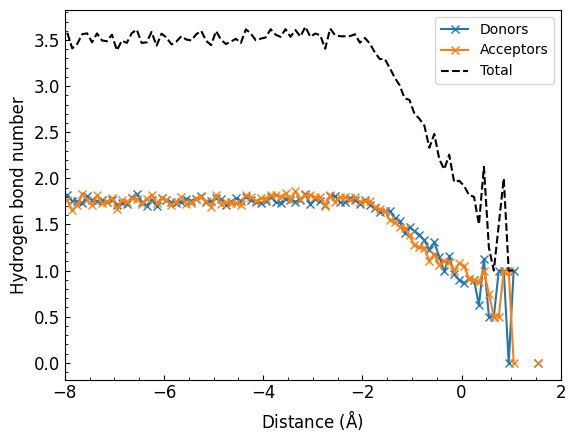

In [4]:
donor_dat = np.loadtxt('./outputs/donor.dat')
don_x = donor_dat[:,0]
don_y = donor_dat[:,1]
accept_dat = np.loadtxt('./outputs/acceptor.dat')
acc_x = accept_dat[:,0]
acc_y = accept_dat[:,1]
tot_x = don_x   
tot_y = [don_y[i]+acc_y[i] for i in range(len(don_y))]

fig,ax=plt.subplots()
ax.plot(don_x,don_y,'-x',label='Donors')
ax.plot(acc_x,acc_y,'-x',label='Acceptors')
ax.plot(tot_x,tot_y,'--',color='black',label='Total')

ax.set_xlim(-8,2)
#ax.set_ylim(0,4)
#ax.set_xticks(np.arange(-10,11,2.5))
ax.set_xlabel('Distance ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Hydrogen bond number',size=12)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()

plt.savefig('./outputs/figures/hbond_profile.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [11]:
rdf = WC_inter.surf_RDF()



Calculating RDFs ...


100%|██████████| 200/200 [00:00<00:00, 598.56it/s]


Generating histogram(s)
Done.



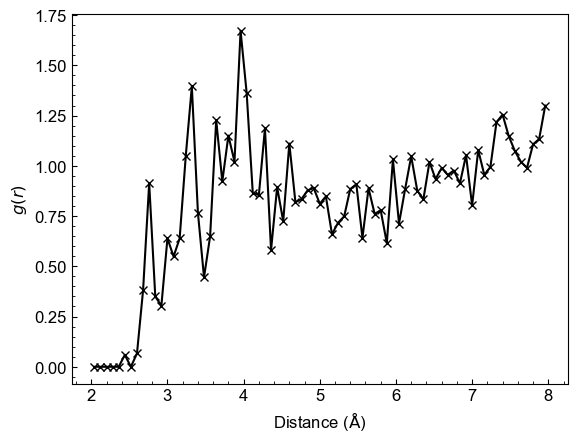

In [12]:
fin = np.loadtxt('./outputs/surf_rdf.dat')
x = fin[:,0]
y = fin[:,1]

fig,ax=plt.subplots()
ax.plot(x,y,'-x',color='black')
ax.set_xlabel('Distance ($\mathrm{\AA}$)',size=12)
ax.set_ylabel(r'$g(r)$',size=12)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig('./outputs/figures/surf_rdf.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()